In [1]:
from trace_extract import parse_trace_file, get_directed
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import pickle as pkl
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
#device = torch.device(2 if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
import time

In [2]:
class RNN_GRU(nn.Module):
    def __init__(self):
        super(RNN_GRU, self).__init__();
        self.gru = nn.GRU(1, 8, 2)
        self.linear = nn.Linear(8, 1)
        self.hidden_state = torch.randn(2, 1, 8, requires_grad=False)
        
    def forward(self, x):#(1, 1, 1) seq_len, batch_size, input_size
        self.hidden_state= self.hidden_state.to(device)
        x, self.hidden_state=self.gru(x, self.hidden_state)#(1, 1, 8)
        #self.hidden_state = self.hidden_state.detach()
        x=x.view(-1);
        x=self.linear(x)
        return x        

In [3]:
def asymetric_loss(output, target, alpha=0.75):
    if (output<target):
        loss = 2.0*alpha*((output - target)**2)
    else:
        loss = 2.0*(1-alpha)*((output - target)**2)
    return loss

In [4]:
class RNN_monitor():
    def __init__(self, self_id, monitoring_id, history_size=16):
        self.ita=100000000;
        self.id = self_id
        self.monitoring = monitoring_id
        self.history_size = history_size
        self.arrival_history = deque(maxlen=history_size)
        #self.margin_history = np.zeros(16);
        self.expected_arrival = 0
        self.safety_margin = Variable(torch.tensor([0]).float()).to(device)
        self.rnn_module = RNN_GRU().to(device);
        self.seq_num = -1;
        self.suspect_intervals=[]
        self.U = 0;
        self.lr=1e-3
        self.decay=1e-6
        self.optimizer=optim.SGD(self.rnn_module.parameters(),
                             lr=self.lr,
                             weight_decay=self.decay)
        self.criterion = asymetric_loss#nn.MSELoss()
        self.loss = 0;
    
    def forward(self, seq_num, arrival_time):
        if (self.seq_num == -1):
            self.seq_num=seq_num
            self.U=arrival_time
            self.arrival_history.append(arrival_time)
            self.expected_arrival = self.U + self.ita;
            x=Variable(torch.tensor([0]).float()).to(device)
            self.safety_margin = self.rnn_module.forward(x.view(1,1,1))
        elif (self.seq_num+1==seq_num):
            start_time=time.time();
            self.rnn_module.zero_grad()
            self.seq_num=seq_num
            if (self.expected_arrival + self.safety_margin.item()*self.ita < arrival_time):
                self.suspect_intervals.append([self.expected_arrival + self.safety_margin, arrival_time])
            self.arrival_history.append(arrival_time)
            #print("append arrival:", time.time()-start_time);start_time=time.time();
            optimal_margin = (arrival_time-self.expected_arrival)/self.ita
            #self.margin_history=np.roll(self.margin_history, -1);
            #self.margin_history[-1]=optimal_margin
            target = Variable(torch.tensor([optimal_margin]).float()).to(device)
            #print("compute optimal:", time.time()-start_time);start_time=time.time();
            self.optimizer.zero_grad()
            self.loss= self.criterion(self.safety_margin, target)
            #print("compute loss:", time.time()-start_time);start_time=time.time();
            self.loss.backward()
            self.rnn_module.hidden_state = self.rnn_module.hidden_state.detach()
            self.optimizer.step()
            #print("back prop:", time.time()-start_time);start_time=time.time();
            input_x = Variable(torch.tensor([optimal_margin]).float()).to(device)            
            self.safety_margin = self.rnn_module.forward(input_x.view(1,1,1))
            #print("estimate next:", time.time()-start_time);start_time=time.time();
            self.cal_expectation()
            
        elif (self.seq_num<seq_num):
            self.seq_num=seq_num
            self.arrival_history.clear();
            self.U=arrival_time
            self.arrival_history.append(arrival_time)
            self.expected_arrival = self.U + self.ita;
    
    def cal_expectation(self):
        if (len(self.arrival_history)<self.history_size):
            k = len(self.arrival_history);
            temp_U = self.arrival_history[-1]/(k)+(k-1)*self.U/(k)
            self.U = temp_U
            self.expected_arrival = self.U + (k+1)/2*self.ita;
        else:
            temp = (self.arrival_history[-1]-self.arrival_history[0])/(self.history_size-1)
            self.expected_arrival += temp
        return self.expected_arrival

    def combine_hidden_state(self, other_state, alpha=0.9):
        self.rnn_module.hidden_state=alpha*self.rnn_module.hidden_state+(1-alpha)*other_state
        self.rnn_module.hidden_state=self.rnn_module.hidden_state.detach();

In [5]:
def get_traces(trace_list):
    traces=[]
    lens=[]
    for p in trace_list:
        u = p[0]; v = p[1];
        temp_t, temp_l = get_directed(u, v);
        traces.append(temp_t)
        lens.append(temp_l)
    return traces, lens

In [6]:
def create_monitors(trace_list, monitor_type):
    monitors=[]
    for p in trace_list:
        u = p[0]; v = p[1];
        monitors.append(monitor_type(u, v))
    return monitors

In [7]:
trace_list = [(1, 0), (3, 0), (4, 0)]
num_traces = len(trace_list)
traces, lens = get_traces(trace_list)

In [8]:
def check_aligned(pointers, traces, num_traces):
    for i in range(num_traces-1):
        if (traces[i][pointers[i]][0] != traces[i+1][pointers[i+1]][0]):
            return False;
    return True;

def align_heartbeat(pointers, traces, num_traces):
    while (not check_aligned(pointers, traces, num_traces)):
        max_n = 0;
        for i in range(num_traces):
            max_n = max(max_n, traces[i][pointers[i]][0])
        for i in range(num_traces):
            while (traces[i][pointers[i]][0]<max_n):
                pointers[i]+=1

def check_end(pointers, traces, num_traces):
    for i in range(num_traces):
        if (pointers[i]>=len(traces[i])):
            return True
    return False

def combine_hidden_state(monitors, num_traces):
    if num_traces==1: 
        return
    temp = monitors[0].rnn_module.hidden_state
    for i in range(1, num_traces):
        temp += monitors[i].rnn_module.hidden_state
    for i in range(num_traces):
        other_state = (temp-monitors[i].rnn_module.hidden_state)/(num_traces-1)
        monitors[i].combine_hidden_state(other_state)

In [9]:
pointers = [0 for i in range(num_traces)]
error_history = []
for i in range(num_traces):
    error_history.append([])
computation_times = []
for i in range(num_traces):
    computation_times.append([])
start_time = []
end_time = [0 for i in range(num_traces)]
monitors = create_monitors(trace_list, RNN_monitor)
count = 0;
while (not check_end(pointers, traces, num_traces)):
    align_heartbeat(pointers, traces, num_traces);
    if (check_end(pointers, traces, num_traces)):
        break;
    for i in range(num_traces):
        n = traces[i][pointers[i]][0]
        t = traces[i][pointers[i]][1]
        if count==0:
            start_time.append(t)
        end_time[i] = t;
        expt=monitors[i].expected_arrival/1e9
        sft=monitors[i].safety_margin.item()/10
        maxt=expt+sft
        error_history[i].append(t/1e9-maxt)
        if (n%5000==1):
            print("monitor from %d to %d:"%(trace_list[i][0], trace_list[i][1]))
            print("expected and safety margin", expt, sft)
            print("maximum waiting time", maxt)
            print("actual time", t/1e9)
            print("RNN loss", monitors[i].loss)
        timestamp=time.time();
        monitors[i].forward(n, t)
        computation_times[i].append(time.time()-timestamp);
        pointers[i]+=1
    combine_hidden_state(monitors, num_traces)
    count+=1;

monitor from 1 to 0:
expected and safety margin 47816598.968825184 0.0005053773522377015
maximum waiting time 47816598.969330564
actual time 47816598.96817092
RNN loss tensor([6.2745e-05], grad_fn=<MulBackward0>)
monitor from 3 to 0:
expected and safety margin 1258014.6475778134 0.0005490648094564676
maximum waiting time 1258014.648126878
actual time 1258014.646732207
RNN loss tensor([7.2762e-05], grad_fn=<MulBackward0>)
monitor from 4 to 0:
expected and safety margin 9301920.748911886 0.0008523225784301758
maximum waiting time 9301920.749764208
actual time 9301920.748021875
RNN loss tensor([5.3741e-05], grad_fn=<MulBackward0>)
monitor from 1 to 0:
expected and safety margin 47817098.96987743 0.0007355101406574249
maximum waiting time 47817098.97061294
actual time 47817098.969323605
RNN loss tensor([0.0050], grad_fn=<MulBackward0>)
monitor from 3 to 0:
expected and safety margin 1258514.6484411235 0.0008847732096910477
maximum waiting time 1258514.6493258968
actual time 1258514.6477909

In [10]:
print(start_time)
print(end_time)
for i in range(num_traces):
    u = trace_list[i][0]; v = trace_list[i][1]
    f=open("../output_data/CoRNN_suspect%d_%d.pkl"%(u, v), "wb");
    pkl.dump(monitors[i].suspect_intervals, f)
    pkl.dump(start_time[i], f)
    pkl.dump(end_time[i], f)
    pkl.dump(error_history[i], f)
    pkl.dump(computation_times[i], f)
    f.close()

[47816110368420886, 1257526047182364, 9301432148369248]
[47818325275020714, 1259740950863456, 9303647055010589]


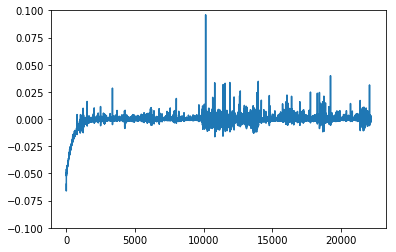

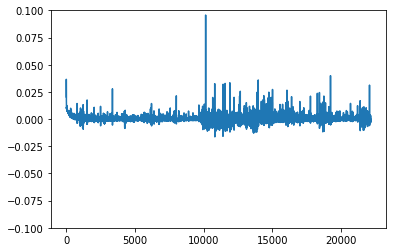

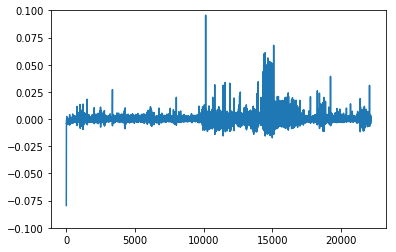

In [11]:
for i in range(num_traces):
    plt.plot(error_history[i][1:])
    plt.ylim(-0.1, 0.1)
    plt.show()